In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dset = pd.read_csv("dataset.csv")
#print(dset.info)
#print(dset.isnull().sum())

#got 12372 sets of data
#12373 rows
#22 columns

In [2]:
#exchange word with number for visiting
frequency_mapping = {
    'never': 0,
    'rarely':1,
    'sometimes': 2,
    'often': 3,
    'very often': 4
}

# replace with numeric
dset['visitPub'] = dset['visitPub'].replace(frequency_mapping)
dset['visitCoffeeHouse'] = dset['visitCoffeeHouse'].replace(frequency_mapping)
dset['visitFastFood'] = dset['visitFastFood'].replace(frequency_mapping)
dset['visitFoodCourt'] = dset['visitFoodCourt'].replace(frequency_mapping)
dset['visitRestaurant'] = dset['visitRestaurant'].replace(frequency_mapping)

# fill with median
dset['visitPub'].fillna(dset['visitPub'].median(), inplace=True)
dset['visitCoffeeHouse'].fillna(dset['visitCoffeeHouse'].median(), inplace=True)
dset['visitFastFood'].fillna(dset['visitFastFood'].median(), inplace=True)
dset['visitFoodCourt'].fillna(dset['visitFoodCourt'].median(), inplace=True)
dset['visitRestaurant'].fillna(dset['visitRestaurant'].median(), inplace=True)

income_mapping = {
    '$87500 - $99999': 93749.5,
    '$50000 - $62499': 56249.5,
    '$100000 or More': 100000,  #using 10000 as mean
    'Less than $12500': 12500,  #using 12500 as mean
    '$12500 - $24999': 18749.5,
    '$25000 - $37499': 31249.5,
    '$75000 - $87499': 81249.5,
    '$62500 - $74999': 68749.5,
    '$37500 - $49999': 43749.5
}

# 使用映射字典将收入范围转换为中间值
dset['income'] = dset['income'].map(income_mapping)

print(dset.isnull().sum())



gender              0
age                 0
maritalStatus       0
children            0
education           0
income              0
destination         0
passanger           0
weather             0
temperature         0
time                0
visitPub            0
visitCoffeeHouse    0
visitFastFood       0
visitFoodCourt      0
visitRestaurant     0
storeType           0
offerEndSoon        0
moreThan5km         0
moreThan15km        0
sameDirection       0
stopBy(y)           0
dtype: int64


In [4]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numeric_columns = ['age', 'temperature', 'time', 'income', ]
categoric_columns = ['gender', 'maritalStatus', 'education', 'destination', 'passanger', 'weather', 
                     'storeType', 'offerEndSoon']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categoric_columns)
    ])

# 创建Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X = dset.drop('stopBy(y)', axis = 1)
y = dset['stopBy(y)']

# 对特征进行预处理
X_preprocessed = pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=30, stratify=y)



kf = KFold(n_splits=20, shuffle=True, random_state=42)
accuracies = []

for train_index, val_index in kf.split(X_preprocessed):
    X_train, X_val = X_preprocessed[train_index], X_preprocessed[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # 创建梯度提升分类器
    gb_model = GradientBoostingClassifier()

    # 训练模型
    gb_model.fit(X_train, y_train)

    # 预测验证集
    y_pred_val = gb_model.predict(X_val)

    # 评估模型性能
    val_accuracy = accuracy_score(y_val, y_pred_val)
    accuracies.append(val_accuracy)
    
# 计算K折交叉验证的平均准确度
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Validation Accuracy (K-Fold Cross-Validation): {average_accuracy}")


Average Validation Accuracy (K-Fold Cross-Validation): 0.6871161859351391


In [10]:

from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve



# 定义超参数网格
param_grid = {
    'n_estimators': [150, 200],  # 尝试不同的估计器数量
    'learning_rate': [0.1],  # 尝试不同的学习速率
    'max_depth': [7]  # 尝试不同的树深度
}

# 创建Gradient Boosting分类器
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

# 创建Grid Search对象
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# 在数据上执行Grid Search
grid_search.fit(X_train, y_train)

# 输出最佳参数和对应的准确度
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_gb_model = grid_search.best_estimator_

# 计算训练准确度
y_pred_train = best_gb_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Training Accuracy: {train_accuracy:.4f}')

train_precision = precision_score(y_train, y_pred_train)
print(f'Training Precision: {train_precision:.4f}')

train_recall = recall_score(y_train, y_pred_train)
print(f'Training Recall: {train_recall:.4f}')

train_f1 = f1_score(y_train, y_pred_train)
print(f'Training F1 Score: {train_f1:.4f}')


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}
Best Accuracy: 0.7081840411956886
Training Accuracy: 0.8670
Training Precision: 0.8678
Training Recall: 0.9040
Training F1 Score: 0.8855


In [17]:
from sklearn.model_selection import cross_val_score

# Define your Gradient Boosting Classifier
gb_model = GradientBoostingClassifier()

# Define the preprocessor and pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categoric_columns)
    ])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

# Perform cross-validation and calculate accuracy scores
cv_scores1 = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores1, start=1):
    print(f"Fold {i} Accuracy1: {score:.4f}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = cv_scores1.mean()
print(f"Mean Accuracy1: {mean_accuracy:.4f}")

Fold 1 Accuracy1: 0.6840
Fold 2 Accuracy1: 0.6905
Fold 3 Accuracy1: 0.6924
Fold 4 Accuracy1: 0.6791
Fold 5 Accuracy1: 0.6766
Mean Accuracy1: 0.6845


Test Accuracy: 0.8630
Test Precision: 0.8679
Test Recall: 0.8956
Test F1 Score: 0.8815


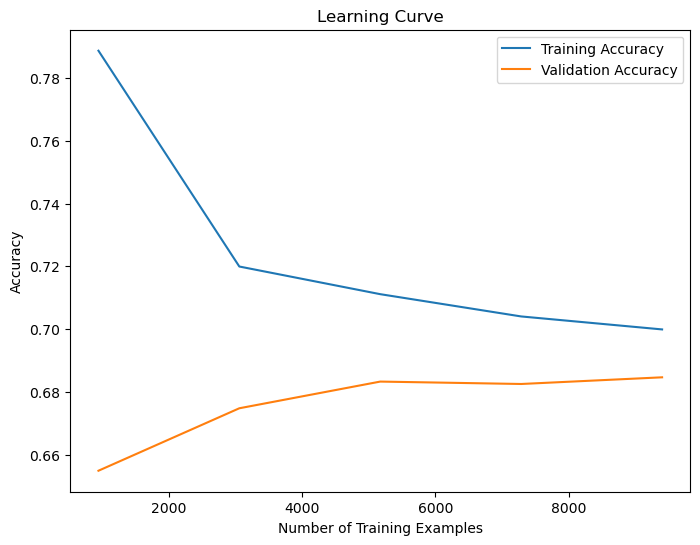

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

# Assuming you have your model already trained and predictions (y_pred) on the test data.
# Replace y_test and y_pred with your actual test labels and predicted labels.

# 计算测试准确度
y_pred_test = best_gb_model.predict(X_test)

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Precision
test_precision = precision_score(y_test, y_pred_test)
print(f'Test Precision: {test_precision:.4f}')

# Recall
test_recall = recall_score(y_test, y_pred_test)
print(f'Test Recall: {test_recall:.4f}')

# F1 Score
test_f1 = f1_score(y_test, y_pred_test)
print(f'Test F1 Score: {test_f1:.4f}')

# ROC AUC Score
#roc_auc = roc_auc_score(y_test, y_pred_prob)  # Assuming you have predicted probabilities as y_pred_prob
#print(f'ROC AUC Score: {roc_auc:.2f}')

# ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label='ROC Curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(gb_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and calculate accuracy scores
cv_scores2 = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores2, start=1):
    print(f"Fold {i} Accuracy2: {score:.4f}")

# Calculate and print the mean accuracy across all folds
mean_accuracy = cv_scores2.mean()
print(f"Mean Accuracy2: {mean_accuracy:.4f}")

Fold 1 Accuracy2: 0.6840
Fold 2 Accuracy2: 0.6905
Fold 3 Accuracy2: 0.6924
Fold 4 Accuracy2: 0.6791
Fold 5 Accuracy2: 0.6766
Mean Accuracy2: 0.6845
